In [ ]:
import zipfile


def unzip_file(zip_path, extract_to):
    """
    Unzips a file to the specified directory.

    :param zip_path: Path to the zip file
    :param extract_to: Directory to extract the contents to
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
zip_path = '/content/drive/MyDrive/Copy of generated_images_10Kids_cropped.zip'
extract_to = 'images'
unzip_file(zip_path, extract_to)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense
from tensorflow.keras.models import Model
import numpy as np
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from sklearn.model_selection import train_test_split
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[:, :128], y_pred[:, 128:256], y_pred[:, 256:]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
    return loss

def create_triplet(image_paths):
    folders = list(image_paths.keys())

    anchor_folder = random.choice(folders)
    anchor_image = random.choice(image_paths[anchor_folder])

    positive_image = random.choice(image_paths[anchor_folder])
    while positive_image == anchor_image:
        positive_image = random.choice(image_paths[anchor_folder])

    negative_folder = random.choice(folders)
    while negative_folder == anchor_folder:
        negative_folder = random.choice(folders)
    negative_image = random.choice(image_paths[negative_folder])

    return anchor_image, positive_image, negative_image

def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0
    return image

def generate_triplet_batch(image_paths, batch_size=32, target_size=(128, 128)):
    while True:
        anchor_batch = []
        positive_batch = []
        negative_batch = []

        for _ in range(batch_size):
            anchor_image, positive_image, negative_image = create_triplet(image_paths)
            anchor_batch.append(load_and_preprocess_image(anchor_image, target_size))
            positive_batch.append(load_and_preprocess_image(positive_image, target_size))
            negative_batch.append(load_and_preprocess_image(negative_image, target_size))

        yield [np.array(anchor_batch), np.array(positive_batch), np.array(negative_batch)], np.zeros(batch_size)

def split_data(data_dir, test_size=0.2):
    folders = os.listdir(data_dir)
    train_folders, val_folders = train_test_split(folders, test_size=test_size, random_state=42)

    train_image_paths = {folder: [os.path.join(data_dir, folder, img) for img in os.listdir(os.path.join(data_dir, folder))] for folder in train_folders}
    val_image_paths = {folder: [os.path.join(data_dir, folder, img) for img in os.listdir(os.path.join(data_dir, folder))] for folder in val_folders}

    return train_image_paths, val_image_paths

data_dir = '/content/images/generated_images_10Kids_cropped'
train_image_paths, val_image_paths = split_data(data_dir)
train_generator = generate_triplet_batch(train_image_paths, batch_size=32, target_size=(128, 128))
val_generator = generate_triplet_batch(val_image_paths, batch_size=32, target_size=(128, 128))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense
from tensorflow.keras.models import Model

def unet_embedding(input_shape=(128, 128, 3), embedding_dim=128):
    inputs = Input(shape=input_shape)

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    bottleneck = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    bottleneck = Conv2D(512, (3, 3), activation='relu', padding='same')(bottleneck)


    up6 = UpSampling2D(size=(2, 2))(bottleneck)
    up6 = concatenate([up6, conv4], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    flatten = Flatten()(conv9)
    embeddings = Dense(embedding_dim, activation=None)(flatten)

    model = Model(inputs=[inputs], outputs=[embeddings])

    return model

input_shape = (128, 128, 3)
embedding_dim = 128
unet_model = unet_embedding(input_shape=input_shape, embedding_dim=embedding_dim)
unet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

Epoch 1/10
100/100 [==============================] - 146s 1s/step - loss: 39.0976 - val_loss: 0.0574
Epoch 2/10
100/100 [==============================] - 118s 1s/step - loss: 0.0892 - val_loss: 0.0755
Epoch 3/10
100/100 [==============================] - 115s 1s/step - loss: 0.0670 - val_loss: 0.0476
Epoch 4/10
100/100 [==============================] - 118s 1s/step - loss: 0.0523 - val_loss: 0.1114
Epoch 5/10
100/100 [==============================] - 118s 1s/step - loss: 0.0800 - val_loss: 0.0504
Epoch 6/10
100/100 [==============================] - 118s 1s/step - loss: 0.0452 - val_loss: 0.0396
Epoch 7/10
100/100 [==============================] - 115s 1s/step - loss: 0.0465 - val_loss: 0.0436
Epoch 8/10
100/100 [==============================] - 118s 1s/step - loss: 0.0432 - val_loss: 0.0387
Epoch 9/10
100/100 [==============================] - 115s 1s/step - loss: 0.0377 - val_loss: 0.0327
Epoch 10/10
100/100 [==============================] - 118s 1s/step - loss: 0.0810 - val_l

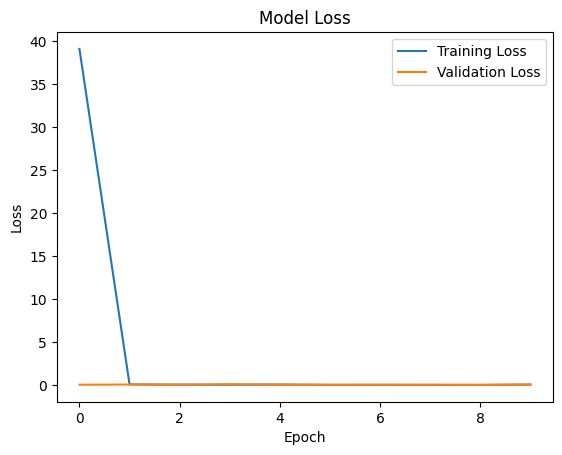

In [ ]:
input_shape = (128, 128, 3)
embedding_dim = 128

unet_model = unet_embedding(input_shape=input_shape, embedding_dim=embedding_dim)

anchor_input = Input(shape=input_shape)
positive_input = Input(shape=input_shape)
negative_input = Input(shape=input_shape)

anchor_embedding = unet_model(anchor_input)
positive_embedding = unet_model(positive_input)
negative_embedding = unet_model(negative_input)

merged_output = tf.keras.layers.concatenate([anchor_embedding, positive_embedding, negative_embedding], axis=1)
triplet_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)

triplet_model.compile(optimizer='adam', loss=triplet_loss)

history = triplet_model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_generator,
    validation_steps=20
)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
unet_model.save('unet_triplet_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

unet_model = load_model('unet_triplet_model.keras', compile=False)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0
    return np.expand_dims(image, axis=0)

def get_embedding(model, image_path):
    image = load_and_preprocess_image(image_path)
    embedding = model.predict(image)
    return embedding[0]

def euclidean_distance(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

def distance_to_probability(distance, scale=1.0):
    return np.exp(-distance / scale)
def compare_faces(model, image1_path, image2_path, threshold=0.5):
    embedding1 = get_embedding(model, image1_path)
    embedding2 = get_embedding(model, image2_path)

    distance = euclidean_distance(embedding1, embedding2)
    probability = distance_to_probability(distance)

    if probability > threshold:
        print(f'Probability: {probability:.4f} - The faces are the same.')
    else:
        print(f'Probability: {probability:.4f} - The faces are different.')

    return probability
image1_path = '/content/images/generated_images_10Kids_cropped/00001/002_00001.png'
image2_path = '/content/images/generated_images_10Kids_cropped/00001/003_00001.png'
compare_faces(unet_model, image1_path, image2_path)


1/1 [==============================] - 0s 18ms/step
Probability: 0.7588 - The faces are the same.


0.7587741080974431

In [ ]:
import zipfile

def zip_model_file(model_file_path, zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(model_file_path, arcname=os.path.basename(model_file_path))
model_file_path = 'unet_triplet_model.keras'
zip_file_path = 'unet_triplet_model.zip'

zip_model_file(model_file_path, zip_file_path)
